In [1]:
import cv2
import numpy as np 
import random
import torch 
from torch import nn
from torchvision import datasets, transforms,utils
import matplotlib.pyplot as plt
import tqdm.notebook as tdm
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

transform1 = transforms.Compose([transforms.ToTensor(), ]) # range [0, 255] -> [0.0,1.0]
transform2 = transforms.Compose([transforms.ToTensor(),  transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])  

In [2]:

def pic_r(pic=np.ndarray(1)):
    x,y,r = random.randint(-12,12),random.randint(-12,12),random.randint(-50,50)
    
    M=cv2.getRotationMatrix2D((19,19),r,1)
    picrt=cv2.warpAffine(pic,M,(50,50))
    
    picrt=cv2.resize(picrt,(40+x,40+y))
    
    M=cv2.getRotationMatrix2D(((40+x)//2,(40+y)//2),r,0.8)
    picrt=cv2.warpAffine(picrt,M,(48,48))
    
    ret = transform1(picrt).numpy()
    return ret

imgorg={0:np.zeros((35, 35, 3))}

for i in range(26):
    C= i+1
    picpath='C:/ctf/pic/images/y_%02d.png'%(i+1)
    imgorg[C]=~cv2.imread(picpath,1)[3:40,3:40]

t_x=[]
t_y=[]
for i in tdm.trange(2000):
    for j in imgorg:
        t_x.append(pic_r(imgorg[j]))
        t_y.append(j)
p_x=[]
p_y=[]
for i in tdm.trange(100):
    for j in imgorg:
        p_x.append(pic_r(imgorg[j]))
        p_y.append(j)


len(t_x),len(p_y),len(p_x)

(54000, 2700, 2700)

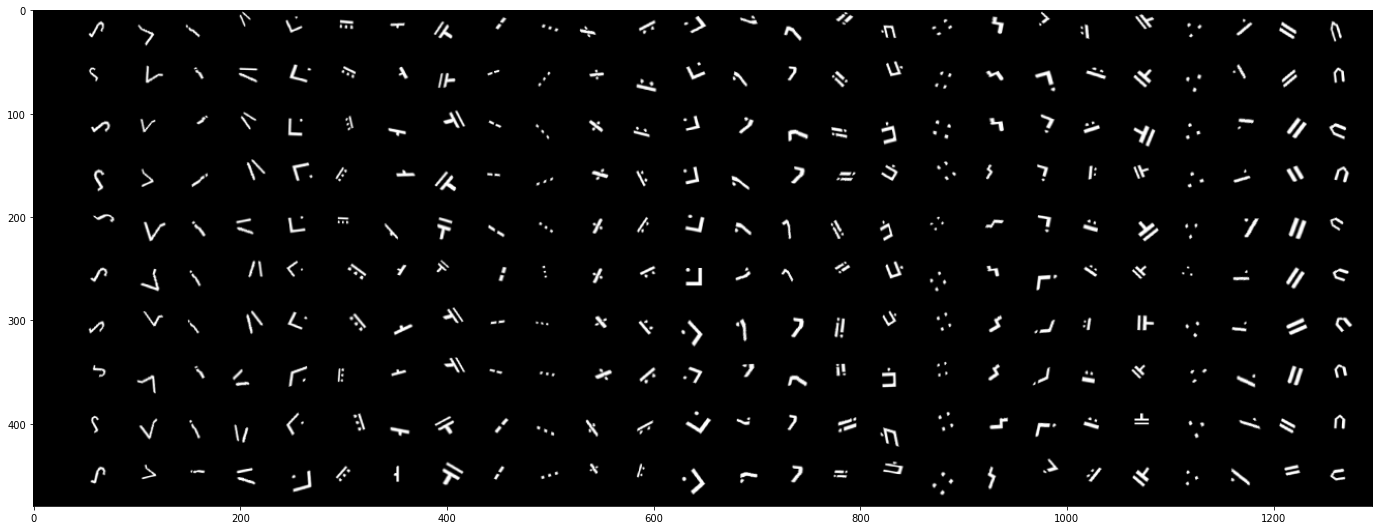

In [3]:
imgs=torch.tensor(t_x[:27*10])
grid = utils.make_grid(imgs,27,padding=0)
grid2 = grid.numpy().transpose(1,2,0) 
plt.figure(figsize=(24,24))
# # plt.figure(figsize=(20,20))
plt.imshow(grid2)
plt.show()



In [4]:
b_size=32

import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,b_size,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(b_size,64,kernel_size=3,stride=1,padding=1)
        self.fh0 = nn.Linear(9216,1024*3)#两个池化，
        self.fh2 = nn.Linear(1024*3,256)
        
        self.fo = nn.Linear(256,32)
        self.dp = nn.Dropout(p=0.3)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1,9216)
        x = F.relu(self.fh0(x))
        x = self.dp(x)
        x = F.relu(self.fh2(x))  
        x = self.dp(x)
        x = self.fo(x)  
        return x
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    fig, axes = plt.subplots(1, 2, figsize=[16, 5])
    sns.lineplot(iters, costs,color='red',label=label_cost, ax = axes[0]) 
    sns.lineplot(iters, accs,color='green',label=lable_acc,ax=axes[1]) 
    plt.show()




In [14]:
net = CNN()

#net.load_state_dict(torch.load('c:/CTF/ctfshow_mr.ai'))

In [6]:
t_x = torch.tensor(np.array(t_x), dtype=torch.float)
t_y= torch.tensor(np.array(t_y), dtype=torch.long)

p_x = torch.tensor(np.array(p_x), dtype=torch.float)
# p_y= torch.tensor(np.array(p_y), dtype=torch.long)
len(t_x)
# q_x = torch.tensor(np.array(q_x), dtype=torch.float)
# q_y= torch.tensor(np.array(q_y), dtype=torch.long)
len(p_y)

2700


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.95      0.98      0.97       100
           2       0.98      1.00      0.99       100
           3       0.94      0.95      0.95       100
           4       0.99      0.98      0.98       100
           5       0.99      0.99      0.99       100
           6       0.96      0.94      0.95       100
           7       0.99      0.98      0.98       100
           8       0.96      0.98      0.97       100
           9       0.95      0.94      0.94       100
          10       1.00      0.98      0.99       100
          11       0.97      0.92      0.94       100
          12       0.94      0.98      0.96       100
          13       0.99      0.99      0.99       100
          14       0.80      0.79      0.79       100
          15       0.83      0.81      0.82       100
          16       0.92      0.97      0.94       100
          17       0.96   

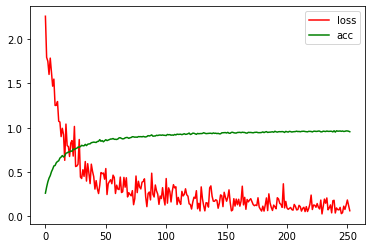

In [15]:
import datetime as dt
import tqdm.notebook as tqnb
tstart=dt.datetime.now()
train_accs = []
train_loss = []



device = "cpu" 
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pxd=p_x.to(device)
net.to(device)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(net.parameters(),lr=0.001)#Adam优化方法比较时髦

roundx=30
pbar = tqnb.tqdm(total=len(t_x)//b_size*roundx)
error=[]
zql=[]
cont=0
for epoch in range(roundx):
    for i  in  range(0,len(t_x),b_size):

        cont+=1
        inputs,labels = t_x[i:i+b_size].to(device), t_y[i:i+b_size].to(device)
        optimizer.zero_grad()         
        #前向+后向+优化     

        outputs = net.forward(inputs.to(device))
        loss = criterion(outputs,labels.to(device))
        loss.backward()
        optimizer.step()
        pbar.update(1)
        if cont%200 == 0 :
            yp=[]
            for pcnt in range(0,len(pxd),32): 
                y_pred = net(pxd[pcnt:pcnt+32])
                y_pred = torch.argmax(y_pred, dim=1).cpu()
                yp.extend(y_pred.numpy())
            zql.append(float(accuracy_score(p_y,yp )))
            error.append(loss.item())
pbar.close()

dt.datetime.now()-tstart

import seaborn as sns

sns.lineplot(data=error,color='red',label='loss')
sns.lineplot(data=zql,color='green',label='acc')
print(classification_report(p_y, yp))

torch.cuda.empty_cache()

In [10]:
#torch.save(net.state_dict(),'c:/CTF/ctfshow_mr.ai')

In [12]:
#torch.save(net.state_dict(),'c:/CTF/ctfshow_mr.ai')
m=u'''听说白雪公主在逃跑
小红帽在担心大灰狼
听说疯帽喜欢爱丽丝
丑小鸭会变成白天鹅
听说彼得潘总长不大
杰克他有竖琴和魔法
听说森林里有糖果屋
灰姑娘丢了心爱的玻璃鞋
只有睿智的河水知道
白雪是因为贪玩跑出了城堡
小红帽有件抑制自己
变成狼的大红袍
总有一条蜿蜒在童话镇里七彩的河
沾染魔法的乖张气息
却又在爱里曲折
川流不息扬起水花
又卷入一帘时光入水
让所有很久很久以前
都走到幸福结局的时刻
听说睡美人被埋藏
小人鱼在眺望金殿堂
听说阿波罗变成金乌
草原有奔跑的剑齿虎
听说匹诺曹总说着谎
侏儒怪拥有宝石满箱
听说悬崖有棵长生树
红鞋子不知疲倦地在跳舞
只有睿智的河水知道
睡美人逃避了生活的煎熬
小人鱼把阳光抹成眼影
投进泡沫的怀抱
总有一条蜿蜒在童话镇里七彩的河
沾染魔法的乖张气息
却又在爱里曲折
川流不息扬起水花
又卷入一帘时光入水
让所有很久很久以前
都走到幸福结局的时刻
总有一条蜿蜒在童话镇里梦幻的河
分隔了理想分隔现实
又在前方的山口汇合
川流不息扬起水花
又卷入一帘时光入水
让所有很久很久以前
都走到幸福结局的时刻 又陌生
弗莱格是：
避席畏闻文字狱_著书只为稻粱谋
记得自己加皮哦'''.encode()
c=[]
for i in m:
    a0=i//26
    a1=i%26
    c.extend([a0+1,a1+1,0])

for p in range(3):
    picout=[]
    for i in c:
        picout.append(pic_r(imgorg[i]))
    imgs=torch.tensor(picout)
    utils.save_image(imgs,'c:/CTF/flag%d.png'%(p+1),27*2,padding=0)

cc=c
len(c),cc,m

(4224,
 [9,
  22,
  0,
  6,
  15,
  0,
  7,
  17,
  0,
  9,
  25,
  0,
  7,
  20,
  0,
  7,
  25,
  0,
  9,
  24,
  0,
  6,
  24,
  0,
  8,
  8,
  0,
  9,
  26,
  0,
  6,
  26,
  0,
  7,
  15,
  0,
  9,
  22,
  0,
  6,
  4,
  0,
  7,
  17,
  0,
  9,
  21,
  0,
  8,
  3,
  0,
  8,
  6,
  0,
  9,
  22,
  0,
  7,
  1,
  0,
  7,
  13,
  0,
  9,
  26,
  0,
  5,
  25,
  0,
  6,
  2,
  0,
  9,
  25,
  0,
  8,
  2,
  0,
  6,
  16,
  0,
  1,
  11,
  0,
  9,
  22,
  0,
  7,
  21,
  0,
  6,
  14,
  0,
  9,
  24,
  0,
  8,
  5,
  0,
  7,
  7,
  0,
  9,
  22,
  0,
  8,
  3,
  0,
  8,
  8,
  0,
  9,
  22,
  0,
  7,
  1,
  0,
  7,
  13,
  0,
  9,
  23,
  0,
  6,
  10,
  0,
  6,
  4,
  0,
  9,
  22,
  0,
  8,
  10,
  0,
  6,
  2,
  0,
  9,
  22,
  0,
  7,
  9,
  0,
  7,
  12,
  0,
  9,
  24,
  0,
  5,
  26,
  0,
  7,
  21,
  0,
  9,
  24,
  0,
  6,
  10,
  0,
  8,
  7,
  0,
  1,
  11,
  0,
  9,
  22,
  0,
  6,
  15,
  0,
  7,
  17,
  0,
  9,
  25,
  0,
  7,
  20,
  0,
  7,
  25,
  0,
  9,
  24,
  0,
 

In [13]:
f1=cv2.imread('c:/CTF/flag1.png',1)
f2=cv2.imread('c:/CTF/flag2.png',1)
f3=cv2.imread('c:/CTF/flag3.png',1)
f1.shape,f3.shape[0]/48,f3.shape[1]/48
row=81
col=54
net.cpu()



def getchars_from_picAfox(fn=''):
    p1=[]
    f1=cv2.imread(fn,1)
    for r in range(0,f1.shape[0],48):
        for c in range(0,f1.shape[1],48):
            appx = f1[r:r+48,c:c+48]
            p1.append(transform1(appx).numpy())
    p1=torch.tensor(np.array(p1[:4326]), dtype=torch.float)
    y1=torch.tensor(np.array(cc), dtype=torch.float)
    y_pred = net(p1)
    y_pred = torch.argmax(y_pred, dim=1)
    return y_pred.numpy()


c1=(getchars_from_picAfox('c:/CTF/flag1.png'))
c2=(getchars_from_picAfox('c:/CTF/flag2.png'))
c3=(getchars_from_picAfox('c:/CTF/flag3.png'))
c1,c2,c3


(array([ 9, 22,  0, ...,  0,  0,  0], dtype=int64),
 array([ 9, 22,  0, ...,  0,  0,  0], dtype=int64),
 array([ 9, 22,  0, ...,  0,  0,  0], dtype=int64))

In [13]:
import pandas as pd
cset=np.array([c1,c2,c3]).T
c=[]
for i in cset:
    c.append(int(np.median(i)))
strx=u''
fwb=[]
for i in range(0,len(c),3):
    w = (c[i]-1)*26+c[i+1]-1
#     print(c[i],c[i+1],hex(w))
    fwb.append(w&0xff)
    strx+=chr(w&0xff)
open('c:/CTF/fw.txt','wb').write(bytes(fwb))
print(fwb)

[229, 143, 172, 232, 175, 180, 231, 153, 189, 233, 155, 170, 229, 133, 172, 228, 184, 187, 229, 156, 168, 233, 128, 131, 232, 183, 145, 6, 229, 176, 143, 231, 186, 162, 229, 184, 189, 229, 156, 168, 230, 139, 133, 229, 191, 131, 229, 164, 167, 231, 129, 176, 231, 139, 188, 10, 229, 144, 172, 232, 175, 180, 231, 150, 175, 229, 184, 189, 73, 150, 156, 230, 172, 162, 231, 136, 177, 228, 184, 189, 228, 184, 157, 10, 228, 184, 145, 229, 176, 143, 233, 184, 173, 228, 188, 154, 229, 143, 152, 230, 136, 144, 231, 153, 189, 229, 164, 169, 233, 185, 133, 10, 229, 144, 172, 232, 175, 180, 229, 189, 188, 229, 190, 151, 230, 189, 152, 230, 128, 187, 233, 149, 191, 228, 184, 141, 229, 164, 167, 10, 230, 157, 176, 229, 133, 139, 228, 187, 150, 230, 156, 137, 231, 171, 150, 231, 144, 180, 229, 146, 140, 233, 173, 148, 230, 179, 149, 10, 229, 144, 172, 232, 175, 180, 230, 171, 174, 230, 158, 151, 233, 135, 140, 230, 156, 137, 231, 179, 150, 230, 158, 156, 229, 177, 139, 10, 231, 129, 176, 229, 167, 145